In [1]:
import pandas as pd
csv_file = pd.read_csv('census.csv')
for col in csv_file.columns:
    print(csv_file[col].dtype)
csv_file

int64
object
int64
object
int64
object
object
object
object
object
int64
int64
int64
object
object


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K


In [2]:
# table of features with types
#[age, education.num, income, capital.loss, native.country, race, hours.per.week, occupation, marital.status]

In [3]:
# Fix column names
csv_file.columns = list(map(lambda x: x.replace('.', '_'), csv_file.columns))
print(csv_file.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')


In [4]:
# Remove features we're not interested in
selected_columns = csv_file.columns.drop(['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital_gain'])
data = csv_file[selected_columns]
print(data.columns)

Index(['age', 'education_num', 'marital_status', 'occupation', 'race',
       'capital_loss', 'hours_per_week', 'native_country', 'income'],
      dtype='object')


In [5]:
# Get counts of missing values
print(len(csv_file.index))
for column in csv_file.columns:
    count = csv_file[column].value_counts().to_frame().sort_index(ascending=True)
    if '?' in count.index:
        print("{0}: {1}".format(count.loc["?"].index[0], count.loc["?"][0]))

32561
workclass: 1836
occupation: 1843
native_country: 583


In [6]:
import numpy as np
def _missing_map(data, label, map_type,  method=np.median, missing='?', class_lab='CLASS'):
    classes = data[data[label] == missing][class_lab].drop_duplicates().values
    means = {}
    for cl in classes:
        
        means[cl] = method(list(map(map_type, data[(data[class_lab] == cl) & 
                                                   (data[label] != missing)][label].values)))
    return means

def set_missing_as_median_by_class(data, label, map_type, missing='?'):
    missing_map_vals = _missing_map(data, label, map_type, missing=missing, class_lab='CLASS')
    for cl in missing_map_vals.keys():
        repl = data[data.CLASS == cl][label].replace([missing], missing_map_vals[cl], regex=False)
        data.loc[data.CLASS == cl, label] = repl


# TODO: use better missing value filler
#csv_file = csv_file.replace('?', np.NaN, label='income')

In [7]:
# break up classes into binary features so numeric functionality like SMOTE works

import patsy
import numpy as np

s = ' + '.join(data.columns) + ' -1' 
print(s)

data = patsy.dmatrix(s, data, return_type='dataframe')
data.columns = list(map(lambda x: x.replace('>', 'over'), data.columns))
print(len(data.columns))

age + education_num + marital_status + occupation + race + capital_loss + hours_per_week + native_country + income -1
71


In [8]:
# We have imbalanced classifications for income >50k, so we can generate extra instances
print(csv_file['income'].value_counts())

<=50K    24720
>50K      7841
Name: income, dtype: int64


In [9]:
# TODO: do something better with SMOTE?

from imblearn.over_sampling import SMOTE
rseed=100

sm = SMOTE(random_state=rseed)
X_res, y_res = sm.fit_sample(data[data.columns.drop(['income[T.over50K]'])], data['income[T.over50K]'])
X_res = pd.DataFrame(X_res, columns=data.columns.drop(['income[T.over50K]']))
y_res = pd.Series(y_res, name='income[T.over50K]')

In [10]:
# ALGORITHMS GO HERE

# right now decision tree is the placeholder approach

#Old cross validation here using stratification
#from sklearn import tree, model_selection
#data_train, data_test, labels_train, labels_test = model_selection.train_test_split(X_res, y_res, random_state=rseed, test_size=0.1,  stratify=y_res)

clf = tree.DecisionTreeClassifier(max_features='auto', random_state=rseed, max_depth=6)


#clf.fit(data_train, labels_train)
#clf.score(data_test, labels_test)

0.79409385113268605

In [11]:
class_predict = clf.predict(data_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels_test, class_predict))

print(class_predict)

             precision    recall  f1-score   support

        0.0       0.91      0.66      0.76      2472
        1.0       0.73      0.93      0.82      2472

avg / total       0.82      0.79      0.79      4944

[ 0.  1.  0. ...,  1.  1.  0.]


In [31]:
#K-Fold cross-validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=100, shuffle=True)
kf.get_n_splits(X_res)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_res, y_res, cv=kf)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.83019822  0.84294094  0.83535599  0.83252427  0.83899676]
Accuracy: 0.84 (+/- 0.01)


In [12]:
#from sklearn.neighbors import NearestNeighbors
#nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(data_train)
#distances, indices = nbrs.kneighbors(data_train)
#distances

In [32]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)

scores = cross_val_score(neigh, X_res, y_res, cv=kf)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.81856796  0.83242314  0.83120955  0.82696197  0.82686084]
Accuracy: 0.83 (+/- 0.01)


Automatically created module for IPython interactive environment


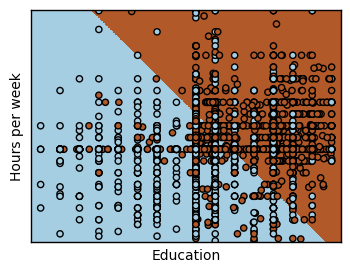

In [29]:
print(__doc__)


# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets

X = np.array(data_test[['education_num', 'hours_per_week']])
Y = labels_test

h = .02  # step size in the mesh

logreg = linear_model.LogisticRegression(C=1e5)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Education')
plt.ylabel('Hours per week')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [16]:
import itertools
import matplotlib.pyplot as plt

# plot_confusion_matrix taken from: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#def plot_confusion_matrix(cm, classes,
#                          normalize=False,
#                          title='Confusion matrix',
#                          cmap=plt.cm.Blues):
#    """
#    This function prints and plots the confusion matrix.
#    Normalization can be applied by setting `normalize=True`.
#    """
#    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#    plt.title(title)
#    plt.colorbar()
#    tick_marks = np.arange(len(classes))
#    plt.xticks(tick_marks, classes, rotation=45)
#    plt.yticks(tick_marks, classes)

#    if normalize:
#        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

#    print(cm)

#    thresh = cm.max() / 2.
#    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#        plt.text(j, i, cm[i, j],
#                 horizontalalignment="center",
#                 color="white" if cm[i, j] > thresh else "black")

#    plt.tight_layout()
#    plt.ylabel('True label')
#    plt.xlabel('Predicted label')
#matrix = confusion_matrix(labels_test, class_predict, labels=[1, 0])
#plt.figure()
#plot_confusion_matrix(matrix, classes=['1', '0'],
#                      title='Confusion matrix')
#plt.show()

In [17]:
#import pydotplus
#from IPython.display import Image  

#dot_data = tree.export_graphviz(clf, out_file=None, 
#                         feature_names=data.columns.drop(['income[T.over50K]']),
#                         class_names=['under_50k', 'over_50k'],  
#                         filled=True, rounded=True,  
#                         special_characters=True)  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png())  

Automatically created module for IPython interactive environment


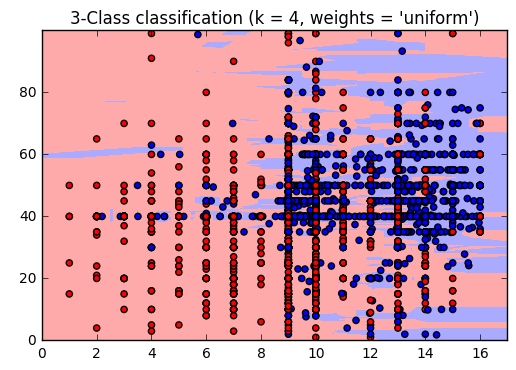

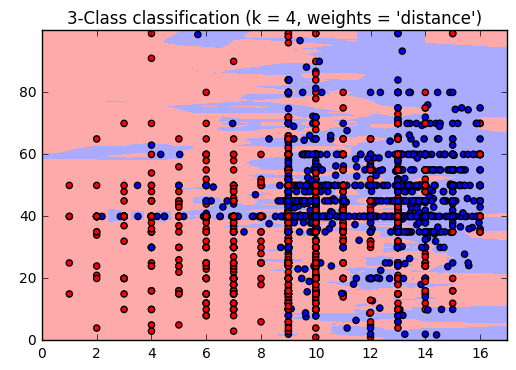

In [15]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 4

X = np.array(data_test[['education_num', 'hours_per_week']])
y = labels_test

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()